# Gerekliliklerin Kurulumları


In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_openai langchain_experimental duckduckgo_search
%pip install -r setup-requirements.txt

# Ortam değişkenlerinin ayarlanması


In [2]:
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = ("X")

# Code çalıştırma aracının kurulumu


In [3]:
from typing import Annotated
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_experimental.utilities import PythonREPL

# Arama aracı
search_tool = DuckDuckGoSearchResults(num_results=5)

# Python REPL aracı
repl = PythonREPL()


# Tool'u tanımlama
@tool
def python_repl_tool(
    code: Annotated[str, "Hesaplama yapmak için çalıştırılacak Python kodu."],
):
    """Python kodu çalıştırmak ve matematik yapmak için bunu kullanın. 
    Bir değerin çıktısını görmek istiyorsanız, bunu `print(...)` ile yazdırmalısınız.
    Bu, kullanıcı tarafından görülebilir."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Çalıştırılamadı. Hata: {repr(e)}"
    result_str = (
        f"Başarıyla çalıştırıldı:\n```python\n{code}\n```\nStandart Çıktı: {result}"
    )
    return result_str

# Ajanların tanımlanması


In [4]:
# Literal kullanımı
from typing import Literal
# LLM tanımlanması
from langchain_openai import ChatOpenAI
# TypedDict kullanımı
from typing_extensions import TypedDict

# OpenAI yerine Anthropic'te kullanabilirsiniz
from langchain_anthropic import ChatAnthropic

# Langgraph'ın kullanımı
from langgraph.graph import MessagesState, END
from langgraph.types import Command

# Ajan takımının üyeleri
members = ["researcher", "coder", "senior_reviewer"]
# Takımımızın denetleyicisi bir LLM düğümüdür.
# Sadece sonraki işleme girecek olan sonraki ajanı seçer 
# ve çalışmanın tamamlandığını belirler
options = members + ["FINISH"]

system_prompt = (
    """
    You are a supervisor tasked with managing a conversation between the following workers: 
    {members}. 
    Given the following user request, respond with the worker to act next. 
    Each worker will perform a task and respond with their results and status. 
    When finished, respond with FINISH.
    
    Always respond in Turkish.
    """
)


class Router(TypedDict):
    """Sonraki ajanı yönlendir. Hiçbir ajan gerekmezse, FINISH'e yönlendir."""

    next: Literal[*options]


llm = ChatOpenAI(model_name="gpt-4o-mini")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

# Ajan nodelarının oluşturulması


In [5]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm,
    tools=[search_tool],
    state_modifier="""
    You are a researcher. DO NOT do any math.
    Always respond in Turkish.
    """,
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state, {"recursion_limit": 25})
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: Bu isteğe bağlı kod çalıştırma işlemidir, bu da güvenli olmayabilir
# NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state, {"recursion_limit": 25})
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


# Add senior reviewer agent
senior_reviewer_agent = create_react_agent(
    llm,
    tools=[search_tool, python_repl_tool],
    state_modifier="""You are a senior reviewer with expertise in code review and technical validation. Your responsibilities include:
    1. Reviewing code quality, accuracy, and potential security issues
    2. Validating research findings and data accuracy
    3. Checking for edge cases and potential errors
    4. Providing specific feedback and improvement suggestions
    5. Ensuring best practices are followed
    
    Always structure your review with:
    - Code Quality Assessment
    - Accuracy Validation
    - Security Concerns (if any)
    - Recommendations

    Always respond in Turkish.
    """,
)


def senior_reviewer_node(state: State) -> Command[Literal["supervisor"]]:
    review_context = """
    Please review the work done by the researcher and coder, focusing on accuracy and potential issues.
    Always respond in Turkish.
    """
    state["messages"].append(HumanMessage(content=review_context))

    result = senior_reviewer_agent.invoke(state, {"recursion_limit": 25})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="senior_reviewer"
                )
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
builder.add_node("senior_reviewer", senior_reviewer_node)
graph = builder.compile()

# Agent graphının oluşturulması


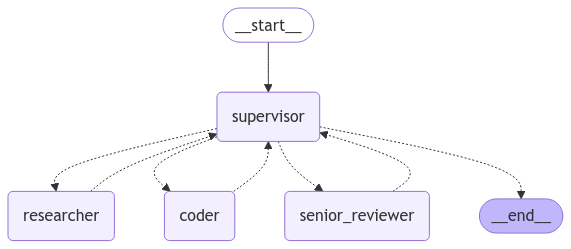

In [6]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

# Agent invokasyonu


In [7]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Son 5 yıldaki Bitcoin fiyat değişimini analiz et."
                "Önemli olayları da grafiğe ekle ve gelecek 6 ay için bir tahmin yap.",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:e0e7d238-2c27-b97a-af03-4f56184b9d4e',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7MLSJqowKFdWbnSF44zoKyDU', 'function': {'arguments': '{"query": "Bitcoin fiyat değişimi son 5 yıl"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 129, 'total_tokens': 171, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3f34124d-f8f8-4792-b33e-75b6941a3e8f-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'Bitcoin fiyat değişimi son 5 yıl'}, 'id': 'call_7MLSJqowKFdWbnSF44zoKy

Python REPL can execute arbitrary code. Use with caution.


(('coder:af2d7b7e-5cbd-cd9d-3dc8-828345f8d259',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eDwMzUObry4OD99E8JRPu4pb', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\nimport numpy as np\\nimport datetime\\n\\n# Bitcoin fiyat verileri (yıllık ortalamalar)\\nyears = np.array([2018, 2019, 2020, 2021, 2022, 2023])\\nprices = np.array([7200, 7400, 11000, 47000, 19000, 40000])  # Ortalama yıllık fiyatlar\\n\\n# Önemli olaylar\\nimportant_events = {\\n    \'2018\': \'Bitcoin fiyatları 20,000 dolardan 3,000 dolara düştü\',\\n    \'2019\': \'Yaz ayında yeniden 13,000 dolara yükseldi\',\\n    \'2020\': \'Covid-19 etkisi ve 29,000 dolara ulaştı\',\\n    \'2021\': \'Nisan 64,000 dolara, sonrasında 47,000 dolara düştü\',\\n    \'2022\': \'20,000-24,000 dolarda işlem gördü\',\\n    \'2023\': \'Eylül ayında 40,000 dolara ulaştı\'\\n}\\n\\n# Grafik\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, prices, marker=\'o\')\\nplt.title(

In [8]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Türkiye'nin Marmara ve Ege bölgelerinin toplam nüfuslarını bul ve ortalamasını hesapla",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:3c786f05-5623-0887-a05a-ef56fcefee22',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ILvc7vnOr9UELODWyQ300sxn', 'function': {'arguments': '{"query": "Marmara bölgesi nüfusu 2023"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}, {'id': 'call_7gxOxU8ZzVrx9I823XbpGadr', 'function': {'arguments': '{"query": "Ege bölgesi nüfusu 2023"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 116, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-859415bd-e30c-47f9-9